In [1]:
cd ../analysis/

/srv/data/home/jlee782/final_segmentation/analysis


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from withClustAnalysis import *
from PixelEM import * 

Populating the interactive namespace from numpy and matplotlib


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
# Pick best clusters for each object sample based on MV
best_clust_df = best_worker_picking()

In [20]:
def plot_best_clust_thresh_metric(metric,gt=""):
    for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
        # we only ran on the best clusters, so the results should only be on the best clusters if not -1
        data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
        data = data[((data["clust"]==-1) &(data["objid"].isin(noClust_obj)))| ((data["clust"]!=-1) & data["objid"].isin(clustObj))]
        plt.plot(data.groupby("num_workers").mean()[metric],label=algo)
        assert len(data.objid.unique())==len(object_lst)
    MV = pd.read_csv("pixel_em/MV_full_PRJ_table.csv") 
    # now need to filter based on best cluster
    MV = filter_best_clust(MV,best_clust_df)
    # select only the best cluster if clustered object -1 if not clustered
    MV = MV[((MV["clust"]==-1) &(MV["objid"].isin(noClust_obj)))| ((MV["clust"]!=-1) & MV["objid"].isin(clustObj))]

    #MV[(MV["num_workers"]==5)&(MV["sample_num"]==9)].sort("objid")
    plt.plot(MV.groupby("num_workers").mean()[metric],label="MV clust")
    MV_noClust = MV.groupby("num_workers").mean()[metric]
    plt.plot(MV_noClust,label="MV no clust")

    plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
    plt.ylabel(metric)
    plt.xticks(rotation=50)
    a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
    if gt:
        plt.title("Ground truth EM [best clust & thresh]",fontsize=13)
    else:
        plt.title("Binary Search Thresh EM [best clust & thresh]",fontsize=13)

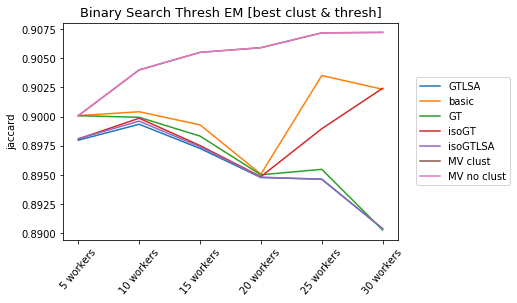

In [23]:
plot_best_clust_thresh_metric("jaccard")

In [5]:
data.groupby(["num_workers","sample_num"]).count()["jaccard"]

num_workers  sample_num
5            0             44
             1             44
             2             44
             3             44
             4             44
             5             44
             6             44
             7             44
             8             44
             9             44
10           0             44
             1             44
             2             44
             3             24
             4             27
             5             22
             6             23
             7             23
15           0             44
             1             44
             2             12
             3             12
             4             12
             5             13
20           0             32
             1             32
             2              7
             3              8
25           0             25
             1             23
30           0             14
Name: jaccard, dtype: int64

In [6]:
clustObj=clust_df.objid.unique()

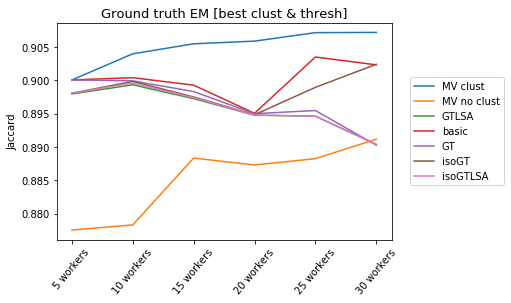

In [7]:
gt=""
MV = pd.read_csv("pixel_em/MV_full_PRJ_table.csv") 
# now need to filter based on best cluster
MV = filter_best_clust(MV,best_clust_df)
# select only the best cluster if clustered object -1 if not clustered
MV = MV[((MV["clust"]==-1) &(MV["objid"].isin(noClust_obj)))| ((MV["clust"]!=-1) & MV["objid"].isin(clustObj))]

#MV[(MV["num_workers"]==5)&(MV["sample_num"]==9)].sort("objid")
plt.plot(MV.groupby("num_workers").mean()["jaccard"],label="MV clust")
plt.plot(MV_noClust,label="MV no clust")

for algo in ['GTLSA',"basic","GT","isoGT","isoGTLSA"]:
    # we only ran on the best clusters, so the results should only be on the best clusters if not -1
    data =  pd.read_csv("pixel_em/{}{}_full_PRJ_table.csv".format(gt,algo))
    data = data[((data["clust"]==-1) &(data["objid"].isin(noClust_obj)))| ((data["clust"]!=-1) & data["objid"].isin(clustObj))]
    plt.plot(data.groupby("num_workers").mean()["jaccard"],label=algo)
    assert len(data.objid.unique())==len(object_lst)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM [best clust & thresh]",fontsize=13)

In [8]:
data.groupby(["num_workers","sample_num"]).count()["jaccard"]

num_workers  sample_num
5            0             44
             1             44
             2             44
             3             44
             4             44
             5             44
             6             44
             7             44
             8             44
             9             44
10           0             44
             1             44
             2             44
             3             14
             4             14
             5             12
             6             13
             7             13
15           0             32
             1             30
             2              7
             3              7
             4              7
             5              8
20           0             15
             1             14
             2              4
             3              4
25           0             14
             1             13
30           0              9
Name: jaccard, dtype: int64

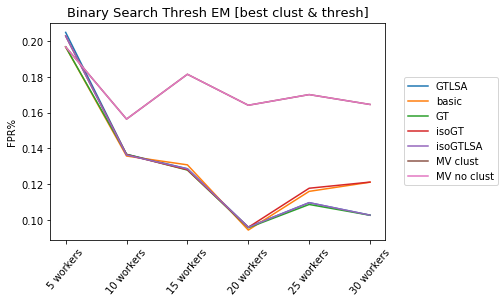

In [21]:
plot_best_clust_thresh_metric("FPR%")

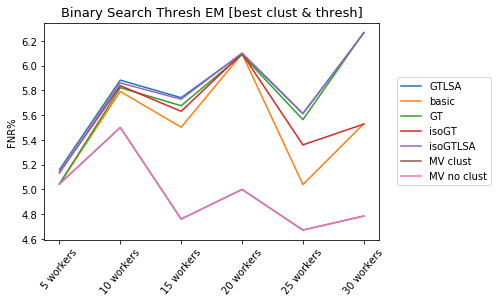

In [22]:
plot_best_clust_thresh_metric("FNR%")

## TPR, FNR 

In [85]:
def TFPNR(result,gt):    
    # True False Positive Negative Rates
    # as defined in https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Definitions
    intersection = len(np.where(((result==1)|(gt==1))&(result==gt))[0])
    gt_area = float(len(np.where(gt==1)[0]))
    result_area = float(len(np.where(result==1)[0]))

    TP = intersection
    FP = result_area - intersection
    FN = gt_area - intersection
    TN = product(shape(result)) - (gt_area+result_area-intersection)

    #TPR = TP/float(TP+FN)
    FPR = FP/float(FP+TN)
    FNR = FN/float(TP+FN)
    #TNR = TN/float(TN+FP)
    #assert TPR+FNR==1 and TNR+FPR==1

    #return  TPR,TNR#,FNR,TNR,FPR
    return FPR*100,FNR*100

In [86]:
result = pkl.load(open("pixel_em/10workers_rand0/obj1/clust0/gt_est_mask_best_thresh.pkl"))
gt = get_gt_mask(1)
TFPNR(result,gt)

(0.09892675150169385, 2.0546898869538652)

In [87]:
result = pkl.load(open("pixel_em/10workers_rand0/obj5/gt_est_mask_best_thresh.pkl"))
gt = get_gt_mask(5)
TFPNR(result,gt)

(0.036945284693106734, 10.496418868856509)